In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
%matplotlib inline
from sklearn.model_selection import train_test_split

For this assignment, I will use a variety of clustering algorithms to look at Boston Marathon data from 2013.

In [2]:
#load data
df = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv')

In [3]:
#look at first few rows of data
df.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [4]:
#get data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


After looking at this overview of the data, it appears that there are a number of variables (10k, 25k, etc.) that we would expect to be floats, but are instead string objects. After looking at the values of these variables, it appears that there are some values of "-". I will replace these dashes with None and convert the rest of the values to floats.

In [5]:
#convert times to float
cols = ['10k', '25k', 'half', '30k', '5k', '20k', '35k', '40k']

for col in cols:
    df[col] = df[col].replace('-', None)
    df[col] = df[col].apply(lambda x: float(x))

Now, I will try a number of clustering models on the data and then evaluate them. First, I will use K-Means with 2, 3, 4, and 5 clusters.

In [6]:
#drop non-numeric variables
X = df.drop(['name', 'gender', 'bib', 'ctz', 'country', 'state', 'city'], axis = 1)

#normalize the data
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

#define blank data frame
ypred = pd.DataFrame()

#break data in half
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

#break halves in half
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

#use k-means to model the data and store the predictions
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 6):
        pred = KMeans(n_clusters=nclust, random_state = 42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

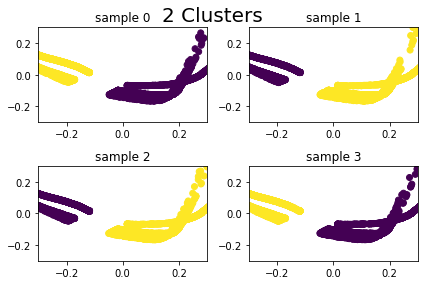

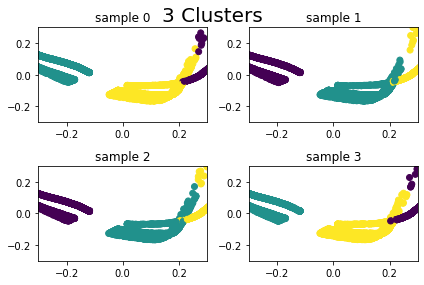

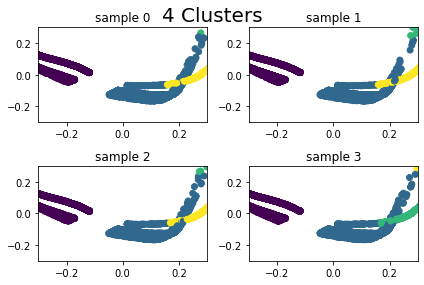

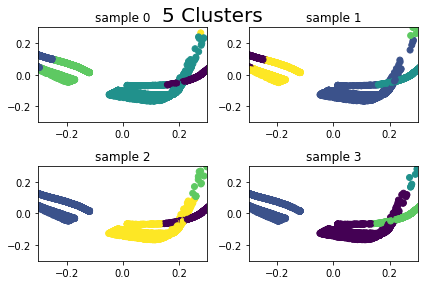

In [7]:
#plot the clusters using the PCA features
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Looking visually at the clusters above, the clusters for each number of clusters look fairly similar. Now, I will use the silhouette score to measure the similarity of the clusters.

In [8]:
#2 clusters
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5140181398973221
0.5177885452292459
0.5114684396386857
0.5170642173193457


In [9]:
#3 clusters
for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=3, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.594155973402707
0.5998441628540112
0.5977300848966661
0.5976097768426263


In [10]:
#4 clusters
for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=4, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.6304503397600163
0.6324146447652416
0.6339500871030818
0.6289355720077285


In [11]:
#5 clusters
for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=5, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5428845055972358
0.542932796484902
0.6373449828895366
0.6321017090643536


Based on the silhouette scores, the clusters were the most similar when there were four clusters. Now, I will look at a mean shift clustering model.

In [12]:
#set bandwidth automatically
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data[0])
    pred = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(data[0])
    labels = ms.labels_
    n_clusters_ = len(np.unique(labels))
    ypred['clust' + str(n_clusters_) + '_sample' + str(counter)] = pred
    print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1
Number of estimated clusters: 1
Number of estimated clusters: 1
Number of estimated clusters: 1


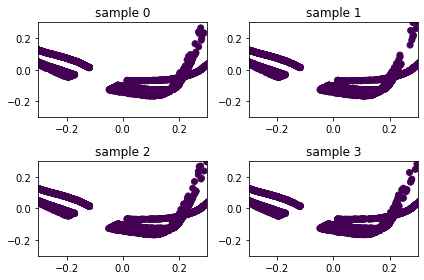

In [13]:
# Make a grid of subplots.
f, axarr = plt.subplots(2, 2)
    
# Make a plot for each sample.
for i in range(4):
        
    # PCA-created features.
    x_sub = ypred['pca_f1_sample{}'.format(i)]
    y_sub = ypred['pca_f2_sample{}'.format(i)]
        
    # Cluster assignments.
    c = ypred['clust{}_sample{}'.format(n_clusters_, i)]
        
    # Assign the subplot to its place on the grid.
    rows = int(np.floor(i / 2))
    cols = i % 2
    axarr[rows, cols].scatter(x_sub, y_sub, c=c)
    axarr[rows, cols].set_title('sample {}'.format(i))
    axarr[rows, cols].set_xlim([-.3, .3])
    axarr[rows, cols].set_ylim([-.3, .3])
    
# Space out the plots so that the headings don't overlap axis values.
plt.tight_layout()
plt.show()
print('\n')

Using the estimate bandwidth function only gives us one cluster. We can try manually changing the bandwidth to see if we can produce more clusters.

In [14]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    ms = MeanShift(bandwidth=0.2, bin_seeding=True)
    ms.fit(data[0])
    pred = MeanShift(bandwidth=0.2, bin_seeding=True).fit_predict(data[0])
    labels = ms.labels_
    n_clusters_ = len(np.unique(labels))
    ypred['clust' + str(n_clusters_) + '_sample' + str(counter)] = pred
    print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 5
Number of estimated clusters: 6
Number of estimated clusters: 6
Number of estimated clusters: 4


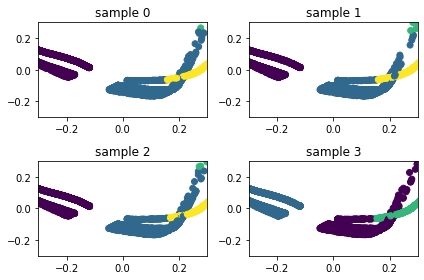

In [15]:
# Make a grid of subplots.
f, axarr = plt.subplots(2, 2)
    
# Make a plot for each sample.
for i in range(4):
        
    # PCA-created features.
    x_sub = ypred['pca_f1_sample{}'.format(i)]
    y_sub = ypred['pca_f2_sample{}'.format(i)]
        
    # Cluster assignments.
    c = ypred['clust{}_sample{}'.format(n_clusters_, i)]
        
    # Assign the subplot to its place on the grid.
    rows = int(np.floor(i / 2))
    cols = i % 2
    axarr[rows, cols].scatter(x_sub, y_sub, c=c)
    axarr[rows, cols].set_title('sample {}'.format(i))
    axarr[rows, cols].set_xlim([-.3, .3])
    axarr[rows, cols].set_ylim([-.3, .3])
    
# Space out the plots so that the headings don't overlap axis values.
plt.tight_layout()
plt.show()
print('\n')

Decreasing the bandwidth allows us to create more than 1 cluster; however, the number of clusters is not consistent throughout the samples, so this is not the clustering algorithm that we want to use. Next, we will try spectral clustering with 2, 3, 4, and 5 clusters.

In [16]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 6):
        pred = SpectralClustering(n_clusters=nclust, random_state = 42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

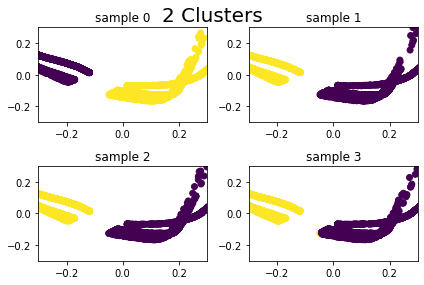

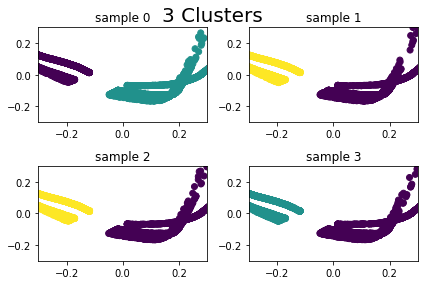

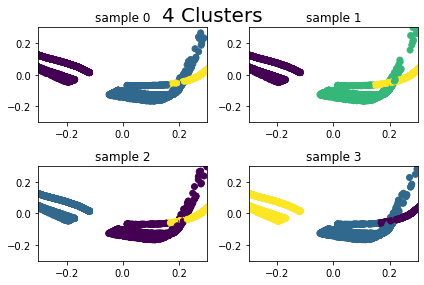

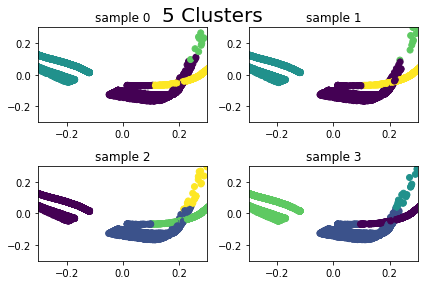

In [17]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Again, these clusters look pretty similar visually, so we will check the silhouette score for each set of clusters.

In [18]:
for sample in [X1, X2, X3, X4]:
    model = SpectralClustering(n_clusters=2, random_state = 42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5140181398973221
0.5177885452292459
0.5114684396386857
0.5164207465614509


In [19]:
for sample in [X1, X2, X3, X4]:
    model = SpectralClustering(n_clusters=3, random_state = 42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5433045809899304
0.5481527209585088
0.5409540233067446
0.5434911044534446


In [20]:
for sample in [X1, X2, X3, X4]:
    model = SpectralClustering(n_clusters=4, random_state = 42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.617666335863283
0.6238941042125425
0.6228436261636489
0.6206111672305193


In [21]:
for sample in [X1, X2, X3, X4]:
    model = SpectralClustering(n_clusters=5, random_state = 42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.6286536907489457
0.6295848084626684
0.6337261800585938
0.6260648894523604


The best spectral clustering models have silhouette scores similar to the best K-means models.

Finally, we will try affinity propagation.

In [22]:
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    af = AffinityPropagation().fit(data[0])
    pred = AffinityPropagation().fit_predict(data[0])
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    print('Estimated number of clusters: {}'.format(n_clusters_))
    ypred['clust' + str(n_clusters_) + '_sample' + str(counter)] = pred

Estimated number of clusters: 2026
Estimated number of clusters: 2575
Estimated number of clusters: 2734
Estimated number of clusters: 2662


This model gives us more than 2000 clusters for each sample, which is not something that we can easily work with. Now, I will use the K-means model with 4 clusters to look more closely at the data.

In [23]:
pred = KMeans(n_clusters=4, random_state = 42).fit_predict(X_norm)
df['cluster'] = pred

When looking at the marathon data, the first thing I wanted to look at was how the overall finishes of the runners were clustered.

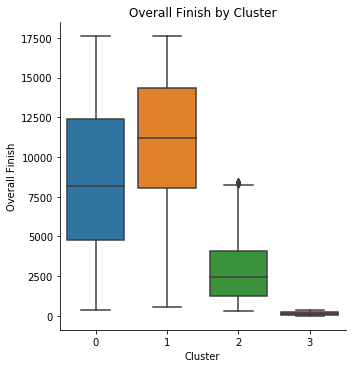

In [24]:
#violin plot
sns.catplot(x='cluster', y= 'overall', kind='box', data= df)
plt.xlabel('Cluster')
plt.ylabel('Overall Finish')
plt.title('Overall Finish by Cluster')
plt.show()

These clusters very accurately cluster the top finishers. They also do a good job of clustering a second tier of finishers, while there is significant overlap between the third and fourth tier finishers. Next, I will look at the finish time by cluster.

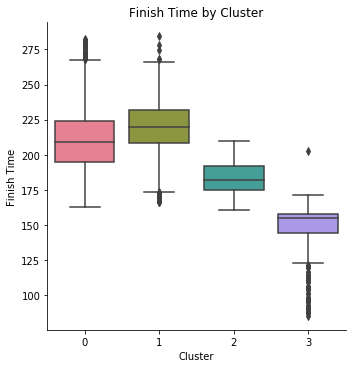

In [25]:
#violin plot
sns.catplot(x='cluster', y= 'official', kind='box', data= df, palette = "husl")
plt.xlabel('Cluster')
plt.ylabel('Finish Time')
plt.title('Finish Time by Cluster')
plt.show()

As expected, this chart looks similar to the chart for the Overall Finish Rank. Next, I will look at the age of the various clusters.

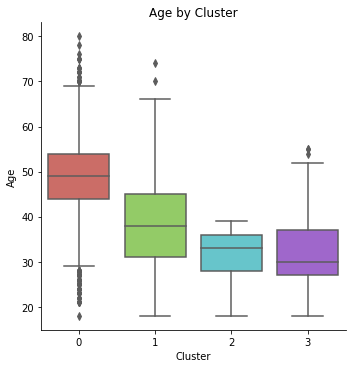

In [26]:
#violin plot
sns.catplot(x='cluster', y= 'age', kind='box', data= df, palette = 'hls')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Age by Cluster')
plt.show()

Here, we see more differentiation between clusters 0 and 1. There is significant overlap between clusters 2 and 3, but that makes sense; we would expect both elite runners and the second tier of runners to be relatively young.

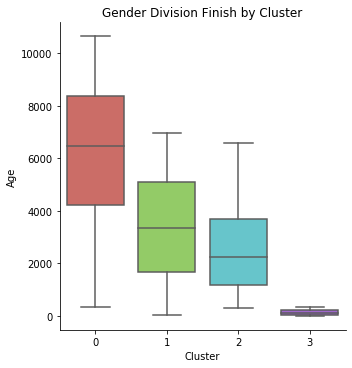

In [27]:
#violin plot
sns.catplot(x='cluster', y= 'genderdiv', kind='box', data= df, palette = 'hls')
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Gender Division Finish by Cluster')
plt.show()

Looking at the finish rank by gender division, we can see further differentiation between cluster 0 and cluster 1. There is significant overlap here between clusters 1 and 2, while cluster 3 clearly contains the most elite runners.